In [1]:
import numpy as np
# import nibabel as nib
import nilearn.plotting as plotting
# import nilearn.image as image
import matplotlib.pyplot as plt
# %matplotlib inline
import hcp_utils as hcp
from PIL import Image
import scipy
import pandas as pd
from plot_functions import *
import seaborn as sns

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
def crop_brain(file,bbox=[160,225,1100,955]):
    img = Image.open(file)
    img = img.crop(bbox)
    img.save(file)
    
def surf_montage(map,data,ref,modes,title):
    if data.shape[0] != 29696:
        raise ValueError('Data should be of shape (29696,n_modes)')
    width = 940
    # montage
    montage = Image.new(mode='RGB', size=(len(modes)*width, 730)) #only works for lateral view
    for i,mode in enumerate(modes):
        if np.dot(data[:,mode],ref[:,mode])<0:
            data[:,mode] = -data[:,mode]
        plotting.plot_surf(map,#hcp.mesh.midthickness_left,
                        hcp.left_cortex_data(data[:,mode],fill=0),
                        cmap='seismic',
                        vmin = -0.015,
                        vmax = 0.015)#,bg_map=hcp.mesh.sulc_left
        plt.savefig('results/brainmaps/tmp/tmp'+str(mode+1)+'.png',dpi=300)
        plt.close()
        crop_brain('results/brainmaps/tmp/tmp'+str(mode+1)+'.png')
        montage.paste(im=Image.open('results/brainmaps/tmp/tmp'+str(mode+1)+'.png'), box=(i*width, 0))
        # print('mode '+str(mode+1)+' done')
    montage.save('results/brainmaps/montages/'+title+'.png')


def parcellate_connectome(data):
    mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
    parcellation = np.loadtxt('BrainEigenmodes/data/parcellations/fsLR_32k_Schaefer200-lh.txt',dtype=int)[mask]
    uns = np.unique(parcellation[parcellation>0])
    newdata = np.zeros((len(uns),len(uns)))
    for i in range(len(uns)):
        for j in range(i+1,len(uns)):
            newdata[i,j] = np.sum(data[parcellation==uns[i],:][:,parcellation==uns[j]])
    return newdata+newdata.T

def plot_connectome1(data,title,vmax=20000):
    data = parcellate_connectome(data)
    plotting.plot_matrix(data,labels=None,cmap='copper',colorbar=False,vmin=0,vmax=vmax,tri='lower')
    #superimpose a white box at indices [50:75,25:50], in which the interior is shown and the box only has an outline
    plt.fill_between([25,50],50,75,color='white',alpha=0.3)
    #set xlabel
    plt.axis('off')
    plt.savefig('results/brainmaps/connectomes/'+title+'.png',dpi=300)
    plt.close()

def plot_connectome2(data,title,vmax=1500):
    data = parcellate_connectome(data)
    data = data[50:75,25:50]
    plotting.plot_matrix(data,labels=None,cmap='copper',colorbar=False,vmin=0,vmax=vmax)
    #set xlabel
    plt.axis('off')
    plt.savefig('results/brainmaps/connectomes/'+title+'.png',dpi=300)
    plt.close()

def prep_connectome(file):
    W = scipy.sparse.load_npz(file)[:29696, :29696]
    W.setdiag(0)
    W.eliminate_zeros() 
    # W = threshold_edges_density(W, 0.001)
    # W = W + A_local
    # W[W>0] = 1
    return W

def plot_eigenvalues(evals,title):
    plt.figure(figsize=(7,5))
    plt.plot(1-evals)
    # plt.xlabel('Eigenvalue index')
    plt.ylabel('$1-\lambda$',fontsize=12)
    plt.ylim([0.85,1])
    plt.xlim([0,200])
    plt.xticks([0,200])
    # plt.set_xticklabels(['1','200'],fontsize=12)
    plt.yticks([0.9,1])
    # plt.set_yticklabels(['0.5','1'],fontsize=12)
    plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
    plt.close()

def save_overlays(mesh_sub,data,title,vmin,vmax):
    mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
    plotting.plot_surf(mesh_sub,hcp.left_cortex_data(data[mask],fill=0),cmap='seismic',vmin=vmin,vmax=vmax)#
    plt.savefig('results/'+title+'.png',dpi=300)
    plt.close()
    crop_brain('results/'+title+'.png')

Run connectome and surface decompositions to also get eigenvalues for 1..1000, only run once

In [4]:
# # compute eigenmodes and eigenvalues for 100307 and average connectome
# from connectome_eigenmodes import construct_A_local,run_connectome_decomposition,compute_normalized_laplacian,compute_eigenmodes
# from surface_eigenmodes import calc_surface_eigenmodes
# surface_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_midthickness-lh.vtk'
# mask_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt'
# A_local = construct_A_local(surface_file,mask_file)

# # template surface
# calc_surface_eigenmodes(surface_file, mask_file, 'results/eigenspectra/template_surface_eval.txt', 'results/eigenspectra/template_surface_emodes.txt', save_cut=True, num_modes=1000)

# # subject-specific surface
# calc_surface_eigenmodes('data/100307/T1w/fsaverage_LR32k/100307.L.midthickness.32k_fs_LR.vtk', mask_file, 'results/eigenspectra/100307_surface_eval.txt', 'results/eigenspectra/100307_surface_emodes.txt', save_cut=True, num_modes=1000)

# # A_local
# L = compute_normalized_laplacian(A_local)
# e_local,v_local = compute_eigenmodes(L,1000)
# np.savetxt('results/eigenspectra/A_local-lh_emode_1000.txt',v_local)
# np.savetxt('results/eigenspectra/A_local-lh_evals_1000.txt',e_local)

# # Group-level connectome, unsmoothed
# connectome_filename = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100.npz'
# run_connectome_decomposition(A_local, connectome_filename,e_local=1,desired_density=0.01,binary=False,output_file='results/eigenspectra/avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.01_weighted_emodes_100.txt',num_modes=1000)

# # Group-level connectome, smoothed
# connectome_filename = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm8.0_100.npz'
# run_connectome_decomposition(A_local, connectome_filename,e_local=1,desired_density=0.01,binary=False,output_file='results/eigenspectra/avg_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes_100.txt',num_modes=1000)

# # Subject-specific connectome, unsmoothed
# connectome_filename = 'data/100307/T1w/tractography/100307_unsmoothed_high_resolution_volumetric_probabilistic_track_endpoints_20M.tck_structural_connectivity.npz'
# run_connectome_decomposition(A_local, connectome_filename,e_local=1,desired_density=0.001,binary=False,output_file='results/eigenspectra/100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_emodes.txt',num_modes=1000)

# # Subject-specific connectome, smoothed
# connectome_filename = 'data/100307/T1w/tractography/100307_smoothed_structural_connectome_20M_fwhm8.0.npz'
# run_connectome_decomposition(A_local, connectome_filename,e_local=1,desired_density=0.01,binary=False,output_file='results/eigenspectra/100307_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes.txt',num_modes=1000)

Eigenmode montages

In [7]:
modes = [0,1,2,3,9,49,99,199]
mesh_sub = 'data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR.surf.gii'
mesh_template = 'results/fs_LR.32k.L.midthickness.surf.gii'
mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)

# template surface
data_template_surface = np.loadtxt('results/eigenspectra/template_surface_emodes.txt')[mask]
surf_montage(map=mesh_template,data=data_template_surface,ref=data_template_surface,modes=modes,title='fsLR_32k_midthickness-lh_emode_200')

# subject specific surface
data_sub_surface = np.loadtxt('results/eigenspectra/100307_surface_emodes.txt')[mask]
surf_montage(map=mesh_sub,data=data_sub_surface,ref=data_template_surface,modes=modes,title='100307_fsLR_32k_midthickness-lh_emode_200')

# A_local
data_A_local = np.loadtxt('results/eigenspectra/A_local-lh_emode_1000.txt')
surf_montage(map=mesh_template,data=data_A_local,ref=data_template_surface,modes=modes,title='A_local-lh_emode_200')

# structural connectome, average, unsmoothed
data_avg_connectome_unsmoothed = np.loadtxt('results/eigenspectra/avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.01_weighted_emodes_100.txt')
surf_montage(map=mesh_template,data=data_avg_connectome_unsmoothed,ref=data_template_surface,modes=modes,title='avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.01_weighted_emodes_100')

# structural connectome, average, best
data_avg_connectome = np.loadtxt('results/eigenspectra/avg_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes_100.txt')
surf_montage(map=mesh_template,data=data_avg_connectome,ref=data_template_surface,modes=modes,title='avg_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes_100')

# structural connectome, subject-specific, unsmoothed
data_subject_connectome_unsmoothed = np.loadtxt('results/eigenspectra/100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_emodes.txt')
surf_montage(map=mesh_sub,data=data_subject_connectome_unsmoothed,ref=data_template_surface,modes=modes,title='100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_emodes')

# structural connectome, subject-specific, best
data_subject_connectome = np.loadtxt('results/eigenspectra/100307_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes.txt')
surf_montage(map=mesh_sub,data=data_subject_connectome,ref=data_template_surface,modes=modes,title='100307_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes')

# random 20mm smoothed
data_random_24 = np.loadtxt('data/100307/T1w/random_data/random_data_24mm_basis.txt')
surf_montage(map=mesh_sub,data=data_random_24,ref=data_template_surface,modes=modes,title='random_data_24mm_basis')

Connectome visualization, takes forever to run

In [21]:
# subject-specific connectome, best
file = 'data/100307/T1w/tractography/100307_smoothed_structural_connectome_20M_fwhm8.0.npz'
W = prep_connectome(file)
plot_connectome1(W,'100307_structural_connectome_20M_fwhm8.0_mat_tri')
plot_connectome2(W,'100307_structural_connectome_20M_fwhm8.0_mat_zoom')

# subject-specific connectome, unsmoothed
file = 'data/100307/T1w/tractography/100307_unsmoothed_high_resolution_volumetric_probabilistic_track_endpoints_20M.tck_structural_connectivity.npz'
W = prep_connectome(file)
plot_connectome1(W,'100307_structural_connectome_20M_fwhm0.0_mat_tri')
plot_connectome2(W,'100307_structural_connectome_20M_fwhm0.0_mat_zoom')

# group-level connectome, best
file = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm8.0_100.npz'
W = prep_connectome(file)
plot_connectome1(W,'avg_structural_connectome_20M_fwhm8.0_mat_100_tri')
plot_connectome2(W,'avg_structural_connectome_20M_fwhm8.0_mat_100_zoom')

# group-level connectome, unsmoothed
file = 'results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100.npz'
W = prep_connectome(file)
plot_connectome1(W,'avg_structural_connectome_20M_fwhm0.0_mat_100_tri')
plot_connectome2(W,'avg_structural_connectome_20M_fwhm0.0_mat_100_zoom')

# A_local
from connectome_eigenmodes import construct_A_local
surface_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_midthickness-lh.vtk'
mask_file = 'BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt'
A_local = construct_A_local(surface_file,mask_file)
plot_connectome1(A_local,'A_local_mat_tri',vmax=1)
plot_connectome2(A_local,'A_local_mat_zoom',vmax=1)

--> VTK format         ... 
 --> DONE ( V: 32492 , T: 64980 )



Mesh visualization

In [16]:
# subject-specific mesh
plotting.plot_surf('data/100307/T1w/100307/surf/lh.graymid.surf.gii',
                   surf_map='data/100307/T1w/100307/surf/lh.sulc',
                   cmap='Greys')#
plt.savefig('results/brainmaps/connectomes/100307_midthickness.png',dpi=300)
plt.close()
crop_brain('results/brainmaps/connectomes/100307_midthickness.png',bbox=[120,215,1120,965])

# template mesh
plotting.plot_surf('results/fs_LR.32k.L.midthickness.surf.gii',
                   cmap='Greys')#
plt.savefig('results/brainmaps/connectomes/template_midthickness.png',dpi=300)
plt.close()
crop_brain('results/brainmaps/connectomes/template_midthickness.png',bbox=[160,225,1100,955])

Reconstruction accuracy and AUC

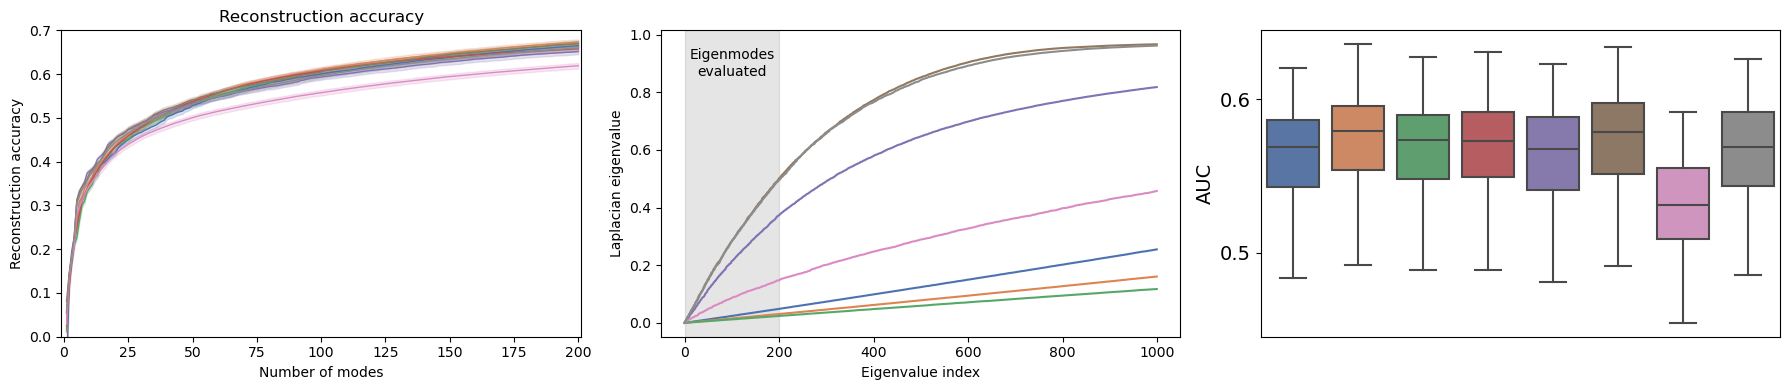

In [20]:
#warnings off
import warnings
warnings.filterwarnings("ignore")
df = pd.read_pickle('reconstruction_accuracies100.pkl')
# task, subject-specific
exp_settings = {'basis':['subject-specific','avg connectome basis','ind. surface','template surface','A_local','random_smoothed_basis'],
                'e_local':['1.0','none'],
                'density':['0.01','none'],
                'binarization':['binary','none'],
                'fwhm':['8.0','none','24'],
                'contrast':np.loadtxt('contrast_list.txt',dtype=str),
                'streamlines':['20M','none']}
df2 = filter_df(df,exp_settings)
df2 = rename_df(df2)
# replace basis name individual connectome with subject specific
df2['Basis'] = df2['Basis'].replace('Individual connectome','Subject-specific connectome (8mm smoothing)')
df2['Basis'] = df2['Basis'].replace('Individual surface','Subject-specific surface')
df2['Basis'] = df2['Basis'].replace('template surface','Template surface')
df2['Basis'] = df2['Basis'].replace('Average connectome','Group-level connectome (8mm smoothing)')
df2['Basis'] = df2['Basis'].replace('A_local','$A_{local}$')
df2['Basis'] = df2['Basis'].replace('Random smoothed basis','Random basis (24mm smoothing)')
exp_settings = {'basis':['subject-specific','avg connectome basis','ind. surface','A_local','random_smoothed_basis'],
                'e_local':['1.0','none'],
                'density':['0.001','0.01','none'],
                'binarization':['binary','none'],
                'fwhm':['0.0'],
                'contrast':np.loadtxt('contrast_list.txt',dtype=str),
                'streamlines':['20M','none']}
df1 = filter_df(df,exp_settings)
#remove the entry of df1 that has avg connectome basis and density 0.001
df1 = df1[~((df1['basis']=='avg connectome basis') & (df1['density']=='0.001'))]
df1 = rename_df(df1)
# replace basis name individual connectome with subject specific
df1['Basis'] = df1['Basis'].replace('Individual connectome','Subject-specific connectome (no smoothing)')
df1['Basis'] = df1['Basis'].replace('Average connectome','Group-level connectome (no smoothing)')
df3 = pd.concat([df1,df2],ignore_index=True)
bases_order = ['Template surface','Subject-specific surface','$A_{local}$','Random basis (24mm smoothing)','Group-level connectome (no smoothing)','Group-level connectome (8mm smoothing)','Subject-specific connectome (no smoothing)','Subject-specific connectome (8mm smoothing)']
df_plot,df_AUC = convert_df(df3,do_df_plot=True)
df_plot,df_AUC = avg_over_tasks(df_plot,df_AUC,which=0,do_df_plot=True)

fig, axs = plt.subplots(1,3,figsize=(18, 4))
# custom_palette = ["green", "purple", "gray","red","blue","k"]
palette = sns.color_palette("deep")
# plt.suptitle(title)
# for i,b in enumerate(bases):
#     sns.lineplot(x='Number of modes',y='Reconstruction accuracy', data=df_plot[df_plot['Basis']==b], ax=axs[0],color=custom_palette[i])
sns.lineplot(x='Number of modes',y='Reconstruction accuracy', data=df_plot, ax=axs[0],palette=palette,hue='Basis',markers=True,hue_order=bases_order,linewidth=1)
#remove legend for axis 0
axs[0].get_legend().remove()
# axs[0].set_xlabel('Method')
axs[0].set_ylabel('Reconstruction accuracy')
axs[0].set_ylim([0,0.7])
axs[0].set_xlim([-1,201])
axs[0].set_title('Reconstruction accuracy')
plt.tight_layout()
# custom_palette = ["gray","purple","green"]
sns.boxplot(x='Basis',y='Reconstruction accuracy',data=df_AUC,ax=axs[2],palette=palette,order=bases_order)
axs[2].set_ylabel('AUC',fontsize=14)
axs[2].set_xlabel('')
axs[2].set_xticks([])
axs[2].set_xticklabels([])
# axs[1].set_xticklabels(bases_order,rotation=15)
axs[2].set_yticks([0.50,0.60])
axs[2].set_yticklabels([0.50,0.60],fontsize=14)
# axs[1].set_ylim(ylim)
# axs[1].set_title('Area under the curve (AUC)',size=16)

################## eigenvalues
# template surface
data_template_surface = np.loadtxt('results/eigenspectra/template_surface_eval.txt')
axs[1].plot(data_template_surface,label='Template surface',color=palette[0])

# subject specific surface
data_sub_surface = np.loadtxt('results/eigenspectra/100307_surface_eval.txt')
axs[1].plot(data_sub_surface,label='Subject-specific surface',color=palette[1])

# A_local
data_A_local = np.loadtxt('results/eigenspectra/A_local-lh_evals_1000.txt')
axs[1].plot(data_A_local,label='$A_{local}$',color=palette[2])

# structural connectome, average, unsmoothed
data_avg_connectome_unsmoothed = np.loadtxt('results/eigenspectra/avg_structural_connectome_20M_fwhm0.0_elocal1.0_density0.01_weighted_emodes_evals.txt')
axs[1].plot(data_avg_connectome_unsmoothed,label='Group-level connectome unsmoothed',color=palette[4])

# structural connectome, average, best
data_avg_connectome = np.loadtxt('results/eigenspectra/avg_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_emodes_evals.txt')
axs[1].plot(data_avg_connectome,label='Group-level connectome smoothed 8mm',color=palette[5])

# structural connectome, subject-specific, unsmoothed
data_subject_connectome_unsmoothed = np.loadtxt('results/eigenspectra/100307_structural_connectome_20M_fwhm0.0_elocal1.0_density0.001_weighted_em_evals.txt')
axs[1].plot(data_subject_connectome_unsmoothed,label='Subject-specific connectome unsmoothed',color=palette[6])

# structural connectome, subject-specific, best
data_subject_connectome = np.loadtxt('results/eigenspectra/100307_structural_connectome_20M_fwhm8.0_elocal1.0_density0.01_weighted_em_evals.txt')
axs[1].plot(data_subject_connectome,label='Subject-specific connectome smoothed 8mm',color=palette[7])

axs[1].axvspan(0, 200, alpha=0.2, color='gray')
#insert text in the gray area
axs[1].text(100, 0.9, 'Eigenmodes\nevaluated', horizontalalignment='center', verticalalignment='center')
axs[1].set_xlabel('Eigenvalue index')
axs[1].set_ylabel('Laplacian eigenvalue')

plt.tight_layout()
plt.savefig('results/brainmaps/reconstruction_accuracies_best.png',dpi=300)

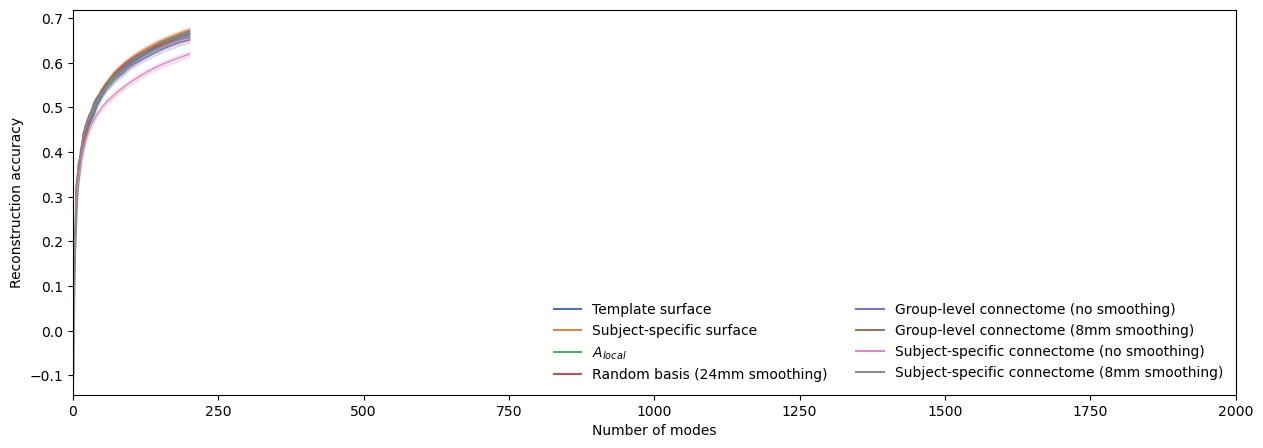

In [17]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Number of modes',y='Reconstruction accuracy', data=df_plot,palette=palette,hue='Basis',markers=True,hue_order=bases_order,linewidth=1)

plt.xlim([0,2000])
plt.legend(loc='lower right',framealpha=0,ncol=2)
plt.savefig('results/brainmaps/reconstruction_accuracies_best_legend.png',dpi=300)

Eigenvalues

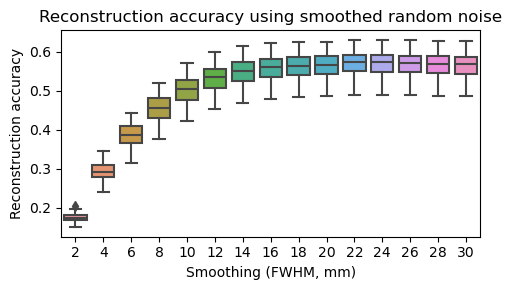

In [12]:
#warnings off
import warnings
warnings.filterwarnings("ignore")
df = pd.read_pickle('reconstruction_accuracies100.pkl')
# task, subject-specific
exp_settings = {'basis':['subject-specific','avg connectome basis','ind. surface','A_local','random_smoothed_basis'],
                'e_local':['1.0','none'],
                'density':['0.01','none'],
                'binarization':['binary','none'],
                'fwhm':['2','4','6','8','10','12','14','16','18','20','22','24','26','28','30'],
                'contrast':np.loadtxt('contrast_list.txt',dtype=str),
                'streamlines':['20M','none']}
df2 = filter_df(df,exp_settings)
df2 = rename_df(df2)
_,df_AUC = convert_df(df2,do_df_plot=False)
_,df_AUC = avg_over_tasks(df_plot,df_AUC,which=0,do_df_plot=False)

#map each fwhm from a string like '2mm' to an integer 2
for fwhm in df_AUC['Smoothing (FWHM)']:
    df_AUC['Smoothing (FWHM)'] = df_AUC['Smoothing (FWHM)'].replace(fwhm,int(fwhm[:-2]))


plt.figure(figsize=(5,3))
sns.boxplot(x='Smoothing (FWHM)',y='Reconstruction accuracy',data=df_AUC)
plt.title('Reconstruction accuracy using smoothed random noise')
plt.xlabel('Smoothing (FWHM, mm)')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('results/brainmaps/reconstruction_accuracies_noise.png',dpi=300)

social_random done
social_tom done
social_tom_random done
motor_cue done
motor_lf done
motor_lh done
motor_rf done
motor_rh done
motor_t done
motor_avg done
motor_cue_avg done
motor_lf_avg done
motor_lh_avg done
motor_rf_avg done
motor_rh_avg done
motor_t_avg done
gambling_punish done
gambling_reward done
gambling_punish_reward done
wm_2bk_body done
wm_2bk_face done
wm_2bk_place done
wm_2bk_tool done
wm_0bk_body done
wm_0bk_face done
wm_0bk_place done
wm_0bk_tool done
wm_2bk done
wm_0bk done
wm_2bk_0bk done
wm_body done
wm_face done
wm_place done
wm_tool done
wm_body_avg done
wm_face_avg done
wm_place_avg done
wm_tool_avg done
language_math done
language_story done
language_math_story done
emotion_faces done
emotion_shapes done
emotion_faces_shapes done
relational_match done
relational_rel done
relational_match_rel done
SSBCAP1 done
SSBCAP2 done
SSBCAP3 done
SSBCAP4 done
SSBCAP5 done
SSBCAP6 done
SSBCAP7 done
SSBCAP8 done
SSBCAP9 done
SSBCAP10 done
SSBCAP11 done
SSBCAP12 done
SSBCAP13 

KeyboardInterrupt: 

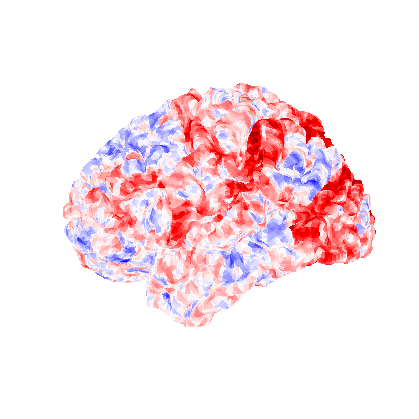

In [9]:
#map of task
mesh_sub = 'data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR.surf.gii'

contrasts = np.loadtxt('contrast_list.txt',dtype=str)
for contrast in contrasts:
    a = np.loadtxt('data/100307/task_txtfiles/'+contrast+'.txt')
    save_overlays(mesh_sub,a,'tasks/'+contrast,vmin=-10,vmax=10)
    print(contrast+' done')

#map of SSBCAP
for i in range(200):
    a = np.loadtxt('data/100307/T1w/Results/SBBCAPs/lh.rfMRI_REST1_LR.res1250.spaceT1w.detrend1_regMov1_zscore1.SSBCAPs_schaefer400yeo7_res1250_spaceT1w_reg'+str(i+1)+'.txt')
    save_overlays(mesh_sub,a,'SSBCAPs/SSBCAP'+str(i+1),vmin=-0.5,vmax=0.5)
    print('SSBCAP'+str(i+1)+' done')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
a = np.arange(-10,11).repeat(10).reshape(10,21)
cax = ax.imshow(a,cmap='seismic')
cbar = fig.colorbar(cax,ticks=[-10,10])
plt.savefig('results/brainmaps/seismic_cbar.png',dpi=300)
plt.close()


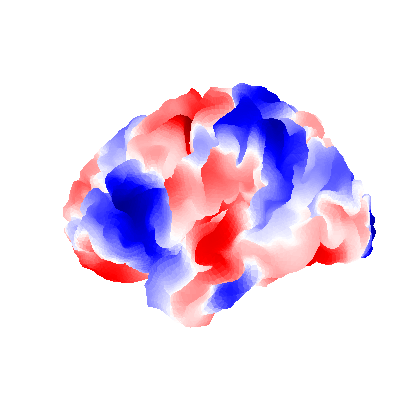

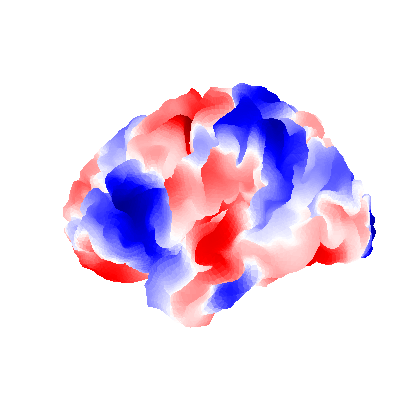

In [23]:
import nibabel as nib
import numpy as np
import nilearn.plotting as plotting
import hcp_utils as hcp
# data = nib.cifti2.load('onetime_usage_scripts/random_data_10mm.dscalar.nii')
# data = data.get_fdata()
# data = np.array(data)[0,:29696]
data = np.loadtxt('data/100307/T1w/random_data/random_data_10mm_basis.txt')[:,3]

mesh_sub = 'data/100307/T1w/fsaverage_LR32k/100307.L.midthickness_MSMAll.32k_fs_LR.surf.gii'
# mask = np.loadtxt('BrainEigenmodes/data/template_surfaces_volumes/fsLR_32k_cortex-lh_mask.txt',dtype=bool)
plotting.plot_surf(mesh_sub,hcp.left_cortex_data(data,fill=0),cmap='seismic')#
# plt.savefig('results/brainmaps/'+title+'.png',dpi=300)
# plt.close()
# crop_brain('results/brainmaps/'+title+'.png')


In [ ]:
evals =[]
evals.append(np.loadtxt('data/100307/T1w/Native/100307.L.midthickness.native_eval.txt'))
evals.append(np.loadtxt('results/avg_connectomes/avg_structural_connectome_20M_fwhm0.0_100_emodes_evals.txt'))
evals.append(np.loadtxt('results/avg_connectomes/100307_structural_connectome_20M_fwhm0.0_emodes_evals.txt'))


fig,axs = plt.subplots(3,1,figsize=(2,5))
for i in range(3):
    axs[i].plot(1-evals[i],linewidth=3)
    axs[i].set_ylabel('$1-\lambda$',fontsize=16)
    axs[i].set_ylim([0.85,1])
    axs[i].set_xlim([0,200])
    if i<2:
        axs[i].set_xticks([])
        axs[i].set_xticklabels([],fontsize=16)
    else:
        axs[i].set_xticks([0,200])
        axs[i].set_xticklabels(['1','200'],fontsize=16)
    axs[i].set_yticks([0.9,1])
    axs[i].set_yticklabels(['0.9','1'],fontsize=16)
plt.savefig('results/brainmaps/evals.png',dpi=300,bbox_inches='tight')